<a href="https://colab.research.google.com/github/sujusudh/Complete-Python-3-Bootcamp/blob/master/mrisubstitution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

In [2]:
!pip install medpy
import medpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 18.8 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.5.2-py3-none-any.whl size=224710 sha256=39698d69ca8aa3d08564fd1295e8be5eb2618a2afbf1e6cf7bacd8fc9bb79085
  Stored in directory: /root/.cache/pip/wheels/89/5a/f8/b3def53b9c2133d2f8698ea2173bb5df63bd8e761ce8e9aec9
Successfully built medpy


In [3]:
from medpy.metric import binary

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [19]:
#import glob
# --- Load MRI from subfolder ---
def load_mri_data(base_dir, patient_id, sequences=[ 'T2','STIR','PSIR','MP2RAGE']):
    patient_dir = os.path.join(base_dir, patient_id)#mri1/sub-001/
    volumes = []#to save the mri sequence files one by one
    patient_idnum=patient_id.split('-')
    values=[1,2,3]
    miss={}
    hit={}
 #take each mri sequence
    for seq in sequences:
      for i in values:
        print("i and seq are",i,seq)
        path = os.path.join(patient_dir,  f'1{i}-{patient_idnum[1]}_{seq}.nii')#mri1/sub-001/t2.nii file path is created and checked
        if not os.path.exists(path):#if not present print as missing
            print(f'Missing: {path}')
            if(seq=='STIR'):
              #build_stir()
              miss['STIR']=path
            elif(seq=='PSIR'):
              #build_psir()
              miss['PSIR']=path
            elif(seq=='MP2RAGE'):
              #build_mp2rage()
              miss['MP2RAGE']=path
            print(miss)
            #return None, None
        else:
            #volume=nib.load(path).get_fdata()
            #volume=np.transpose(volume, (2, 0, 1))
            #patches=extract_3d_patches(volume, patch_size=(64, 64, 64))
            #show_patch_slices(patches[0], title="First Patch")
            if(seq=='STIR'):
              #build_stir()
              hit['STIR']=path
            elif(seq=='PSIR'):
              #build_psir()
              hit['PSIR']=path
            elif(seq=='MP2RAGE'):
              #build_mp2rage()
              hit['MP2RAGE']=path
            #show_patch_slices(patches, title="Patch")
            volumes.append(nib.load(path).get_fdata())#else add the file in the path to volume list
            image=display_image(path)
            print(image.shape)
        #print(volumes)
            print(hit)
    print("done checking seqs")
    #mask_path=glob.glob(os.path.join(patient_dir, '*_LESIONMASK.nii.gz'))#mri1/sub-001/mask.nii file path is created and checked
    for i in values:
      print("i value is",i)
      mask_path = os.path.join(patient_dir, f'1{i}-{patient_idnum[1]}_LESIONMASK.nii')
      if os.path.exists(mask_path):
          #mask_path = nib.load(mask_path).get_fdata()#load the data to mask else print as missing
          mask=display_image(mask_path)
          print(mask)
      else:
          print(f'Missing mask: {mask_path}')
          #return None, None




    stacked = np.stack(volumes, axis=-1)#stack all the files in volume using numpy and return stacked and mask
    print("now we have all the volumes stacked together")

    y=build_seq(hit)

    z=mean_subs(y,miss)
    volumes=volumes.append(z)
    print("we need to stack the volume with the returned mean ")
    stacked = np.stack(z, axis=-1)#stacked the returned normalised values in data
    print("data is ",z)
    return stacked, mask

In [32]:
import numpy as np
import os
import nibabel as nib
import tensorflow as tf
import pickle


# Directory to store subject mean/std
STATS_FILE = "subject_stats.pkl"



def build_seq(hit):
  print("got into build_seq")
  patient_stat={}
  data1 = []
  subject_means = {}
  subject_stds = {}
  for items in hit:
    print(items)
    if(items=='T2'):
      a=build_t2(hit,data,patient_stat)
      print("buildt2 fn called and returned",a)
      #return None

    elif(items=='STIR'):
      a=build_stir(hit,data,patient_stat)
      #return a
      print("buildstir fn called and returned",a)
      #return None

    elif(items=='PSIR'):
      a=build_psir(hit,data,patient_stat)
      #return a
      print("build-psir fn called and returned",a)
      #return None

    elif(items=='MP2RAGE'):
      a=build_mp2rage(hit,data,patient_stat)
      #return a
      print("buildmp2rage fn called and returned",a)
      #return None

  return a


def build_t2(hit,data1,patient_stat):
  print("got into build_t2")
  subject_means = {} # Initialize subject_means locally
  subject_stds = {} # Initialize subject_stds locally
  for mod_name,path in hit.items(): # Iterate over dictionary items
    img_hit = nib.load(path).get_fdata().astype(np.float32)
    mean_val=img_hit.mean()
    std_val=img_hit.std()
 # Store stats for later inversion
    subject_means[mod_name] = mean_val
    subject_stds[mod_name] = std_val

    norm_img = (img_hit - mean_val) / (std_val + 1e-8)
    data1.append(norm_img)

    #patient_id=path.spilt('/')

 # Save stats for this subject
    patient_stat[path] = {
      "mean": subject_means,
      "std": subject_stds
     }
    print("build_t2 ran")
  stackdata=np.stack(data1, axis=-1)  # shape: (H, W, D, num_modalities)
  return data1


def build_stir(hit,data1,patient_stat):
  print("got into build_stir")
  subject_means = {} # Initialize subject_means locally
  subject_stds = {} # Initialize subject_stds locally
  for mod_name,path in hit.items(): # Iterate over dictionary items
    img_hit = nib.load(path).get_fdata().astype(np.float32)
    mean_val=img_hit.mean()
    std_val=img_hit.std()
 # Store stats for later inversion
    subject_means[mod_name] = mean_val
    subject_stds[mod_name] = std_val

    norm_img = (img_hit - mean_val) / (std_val + 1e-8)
    data1.append(norm_img)

    #patient_id=path.spilt('/')

 # Save stats for this subject
    patient_stat[path] = {
      "mean": subject_means,
      "std": subject_stds
     }
    print("build_stir ran")
  stackdata=np.stack(data1, axis=-1)  # shape: (H, W, D, num_modalities)
  return data1

def build_psir(hit,data1,patient_stat):
  #data = [] # Initialize data list locally
  subject_means = {} # Initialize subject_means locally
  subject_stds = {} # Initialize subject_stds locally
  print("got into build_psir")
  for mod_name,path in hit.items(): # Iterate over dictionary items
    img_hit = nib.load(path).get_fdata().astype(np.float32)
    mean_val=img_hit.mean()
    std_val=img_hit.std()
 # Store stats for later inversion
    subject_means[mod_name] = mean_val
    subject_stds[mod_name] = std_val

    norm_img = (img_hit - mean_val) / (std_val + 1e-8)
    data1.append(norm_img)
  # Save stats for this subject
    patient_stat[path] = {
      "mean": subject_means,
      "std": subject_stds
      }
  print("build_psir ran")
  stackdata=np.stack(data1, axis=-1)  # shape: (H, W, D, num_modalities)
  return data1

def build_mp2rage(hit,data1,patient_stat):
  #data = [] # Initialize data list locally
  subject_means = {} # Initialize subject_means locally
  subject_stds = {} # Initialize subject_stds locally
  print("got into build_mp2rage")
  for mod_name,path in hit.items(): # Iterate over dictionary items
    img_hit = nib.load(path).get_fdata().astype(np.float32)
    mean_val=img_hit.mean()
    std_val=img_hit.std()
 # Store stats for later inversion
    subject_means[mod_name] = mean_val
    subject_stds[mod_name] = std_val

    norm_img = (img_hit - mean_val) / (std_val + 1e-8)
    data1.append(norm_img)
  # Save stats for this subject
    patient_stat[path] = {
      "mean": subject_means,
      "std": subject_stds
     }
    print("build_mp2rage ran")
  stackdata=np.stack(data1, axis=-1)  # shape: (H, W, D, num_modalities)
  return data1

  #i have taken the missed modalities and their path and calculated mean and std to find the

In [22]:
def mean_subs(y,miss):
  print("got into mean_subs")
  for i,j in miss.items():
    a=0.1
    b=0.2
    z=[]
    mean_miss=a*y[0]+b*y[1]
    print(mean_miss)
    z=z.append(mean_miss)
  return mean_miss



In [23]:


import nibabel as nib
import matplotlib.pyplot as plt

def display_image(mask_path):

# Load image
  img = nib.load(mask_path)
  img_data = img.get_fdata()


# Get middle slice along each axis
  x_mid = img_data.shape[0] // 2
  y_mid = img_data.shape[1] // 2
  z_mid = img_data.shape[2] // 2

# Plot the slices
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))

  axs[0].imshow(img_data[x_mid, :, :].T, cmap='gray', origin='lower')
  axs[0].set_title('Sagittal (X)')

  axs[1].imshow(img_data[:, y_mid, :].T, cmap='gray', origin='lower')
  axs[1].set_title('Coronal (Y)')

  axs[2].imshow(img_data[:, :, z_mid].T, cmap='gray', origin='lower')
  axs[2].set_title('Axial (Z)')

  plt.tight_layout()
  plt.show()
  img_data.shape
  return img_data

In [24]:
#to display the images and see the size


# --- Config ---
data_dir ="/content/drive/MyDrive/Colab Notebooks/mri1"

#data_dir="content/drive/shared-with-me/mri1"
input_shape = (608, 608, 96, 2)
sequences = [ 'T2', 'STIR', 'PSIR','MP2RAGE']

patient_ids = sorted([name for name in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, name))])
print(patient_ids,'pppp')




['sub-001', 'sub-002'] pppp


In [26]:

# --- Load Dataset ---
def load_dataset(base_dir, patient_ids):
    X, y = [], []
    print(patient_ids)
    for pid in patient_ids:
        v, m = load_mri_data(base_dir, pid)
        if v is not None and m is not None:
            v, m = preprocess_data(v, m)
            X.append(v[0])
            y.append(m[0])
    return np.array(X), np.array(y)

In [27]:
from scipy.ndimage import zoom
import numpy as np

def resize_volume(volume, target_shape):
    zoom_factors = [t / s for t, s in zip(target_shape, volume.shape)]
    return zoom(volume, zoom_factors, order=1)  # Linear interpolation

def preprocess_data(volume, mask, target_shape=(608, 608, 96)):
    # Assume volume shape: (D, H, W, C) and mask shape: (D, H, W)

    # Resize each MRI sequence channel
    resized_channels = []
    for i in range(volume.shape[-1]):
        resized = resize_volume(volume[..., i], target_shape)
        resized_channels.append(resized)
    volume_resized = np.stack(resized_channels, axis=-1)  # (608, 608, 96, 4)

    # Normalize
    volume_resized = (volume_resized - np.min(volume_resized)) / (np.max(volume_resized) - np.min(volume_resized) + 1e-8)

    # Resize mask
    mask_resized = resize_volume(mask, target_shape)
    mask_resized = (mask_resized > 0.5).astype(np.float32)

    # Add batch and channel dims
    volume_resized = np.expand_dims(volume_resized, axis=0)  # (1, D, H, W, 4)
    mask_resized = np.expand_dims(mask_resized, axis=(0, -1))  # (1, D, H, W, 1)

    return volume_resized.astype(np.float32), mask_resized.astype(np.float32)


In [28]:
# --- Define 3D U-Net ---
def build_unet_3d(input_shape):
    inputs = tf.keras.Input(input_shape)

    # Encoder
    c1 = layers.Conv3D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv3D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling3D(2)(c1)

    c2 = layers.Conv3D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv3D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling3D(2)(c2)

    c3 = layers.Conv3D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv3D(64, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling3D(2)(c3)

    c4 = layers.Conv3D(128, 3, activation='relu', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv3D(128, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling3D(2)(c4)

    c5 = layers.Conv3D(256, 3, activation='relu', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv3D(256, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv3DTranspose(128, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv3D(128, 3, activation='relu', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv3D(128, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv3DTranspose(64, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv3D(64, 3, activation='relu', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv3D(64, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv3DTranspose(32, 2, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv3D(32, 3, activation='relu', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv3D(32, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv3DTranspose(16, 2, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv3D(16, 3, activation='relu', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv3D(16, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv3D(1, 1, activation='sigmoid')(c9)
    return models.Model(inputs, outputs)


In [29]:

# --- List patient folders ---
patient_ids = sorted([name for name in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, name))])
print(patient_ids,'pppp')
train_ids = patient_ids[:int(0.8 * len(patient_ids))]
val_ids = patient_ids[int(0.8 * len(patient_ids)):]
print("Found patient folders:", patient_ids)

print("Training patients:", train_ids)
print("Validation patients:", val_ids)


['sub-001', 'sub-002'] pppp
Found patient folders: ['sub-001', 'sub-002']
Training patients: ['sub-001']
Validation patients: ['sub-002']


In [30]:

# --- Build and compile model ---
model = build_unet_3d(input_shape)
model.compile(optimizer=optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 608, 608,  │          0 │ -                 │
│ (InputLayer)        │ 96, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_19 (Conv3D)  │ (None, 608, 608,  │        880 │ input_layer_1[0]… │
│                     │ 96, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 608, 608,  │          0 │ conv3d_19[0][0]   │
│                     │ 96, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_20 (Conv3D)  │ (None, 608, 608,  │      6,928 │ dropout_9[0][0]   │
│                     │ 96, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_4     │ (None, 304, 304,  │          0 │ conv3d_20[0][0]   │
│ (MaxPooling3D)      │ 48, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_21 (Conv3D)  │ (None, 304, 304,  │     13,856 │ max_pooling3d_4[… │
│                     │ 48, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 304, 304,  │          0 │ conv3d_21[0][0]   │
│ (Dropout)           │ 48, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_22 (Conv3D)  │ (None, 304, 304,  │     27,680 │ dropout_10[0][0]  │
│                     │ 48, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_5     │ (None, 152, 152,  │          0 │ conv3d_22[0][0]   │
│ (MaxPooling3D)      │ 24, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_23 (Conv3D)  │ (None, 152, 152,  │     55,360 │ max_pooling3d_5[… │
│                     │ 24, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 152, 152,  │          0 │ conv3d_23[0][0]   │
│ (Dropout)           │ 24, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_24 (Conv3D)  │ (None, 152, 152,  │    110,656 │ dropout_11[0][0]  │
│                     │ 24, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_6     │ (None, 76, 76,    │          0 │ conv3d_24[0][0]   │
│ (MaxPooling3D)      │ 12, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_25 (Conv3D)  │ (None, 76, 76,    │    221,312 │ max_pooling3d_6[… │
│                     │ 12, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 76, 76,    │          0 │ conv3d_25[0][0]   │
│ (Dropout)           │ 12, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_26 (Conv3D)  │ (None, 76, 76,    │    442,496 │ dropout_12[0][0]  │
│                     │ 12, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_7     │ (None, 38, 38, 6, │          0 │ conv3d_26[0][0] 

 Total params: 5,645,345 (21.54 MB)

 Trainable params: 5,645,345 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

['sub-001']
i and seq are 1 T2


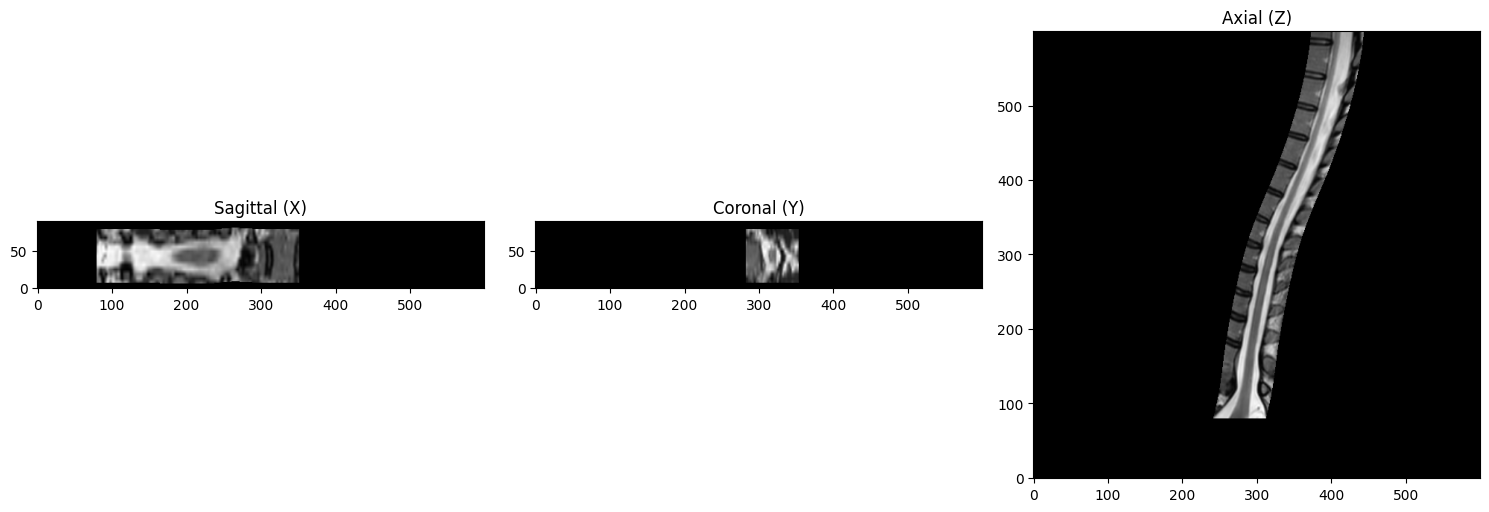

(600, 600, 90)
{}
i and seq are 2 T2
Missing: /content/drive/MyDrive/Colab Notebooks/mri1/sub-001/12-001_T2.nii
{}
i and seq are 3 T2
Missing: /content/drive/MyDrive/Colab Notebooks/mri1/sub-001/13-001_T2.nii
{}
i and seq are 1 STIR


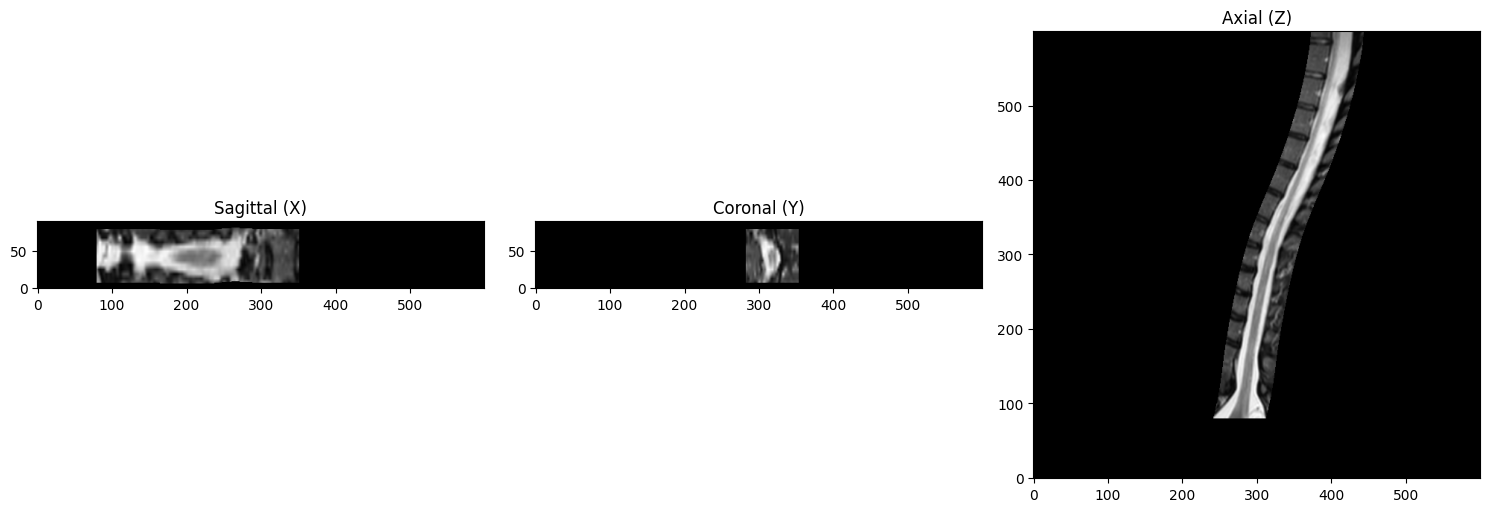

(600, 600, 90)
{'STIR': '/content/drive/MyDrive/Colab Notebooks/mri1/sub-001/11-001_STIR.nii'}
i and seq are 2 STIR
Missing: /content/drive/MyDrive/Colab Notebooks/mri1/sub-001/12-001_STIR.nii
{'STIR': '/content/drive/MyDrive/Colab Notebooks/mri1/sub-001/12-001_STIR.nii'}
i and seq are 3 STIR
Missing: /content/drive/MyDrive/Colab Notebooks/mri1/sub-001/13-001_STIR.nii
{'STIR': '/content/drive/MyDrive/Colab Notebooks/mri1/sub-001/13-001_STIR.nii'}
i and seq are 1 PSIR
Missing: /content/drive/MyDrive/Colab Notebooks/mri1/sub-001/11-001_PSIR.nii
{'STIR': '/content/drive/MyDrive/Colab Notebooks/mri1/sub-001/13-001_STIR.nii', 'PSIR': '/content/drive/MyDrive/Colab Notebooks/mri1/sub-001/11-001_PSIR.nii'}
i and seq are 2 PSIR
Missing: /content/drive/MyDrive/Colab Notebooks/mri1/sub-001/12-001_PSIR.nii
{'STIR': '/content/drive/MyDrive/Colab Notebooks/mri1/sub-001/13-001_STIR.nii', 'PSIR': '/content/drive/MyDrive/Colab Notebooks/mri1/sub-001/12-001_PSIR.nii'}
i and seq are 3 PSIR
Missing: /cont

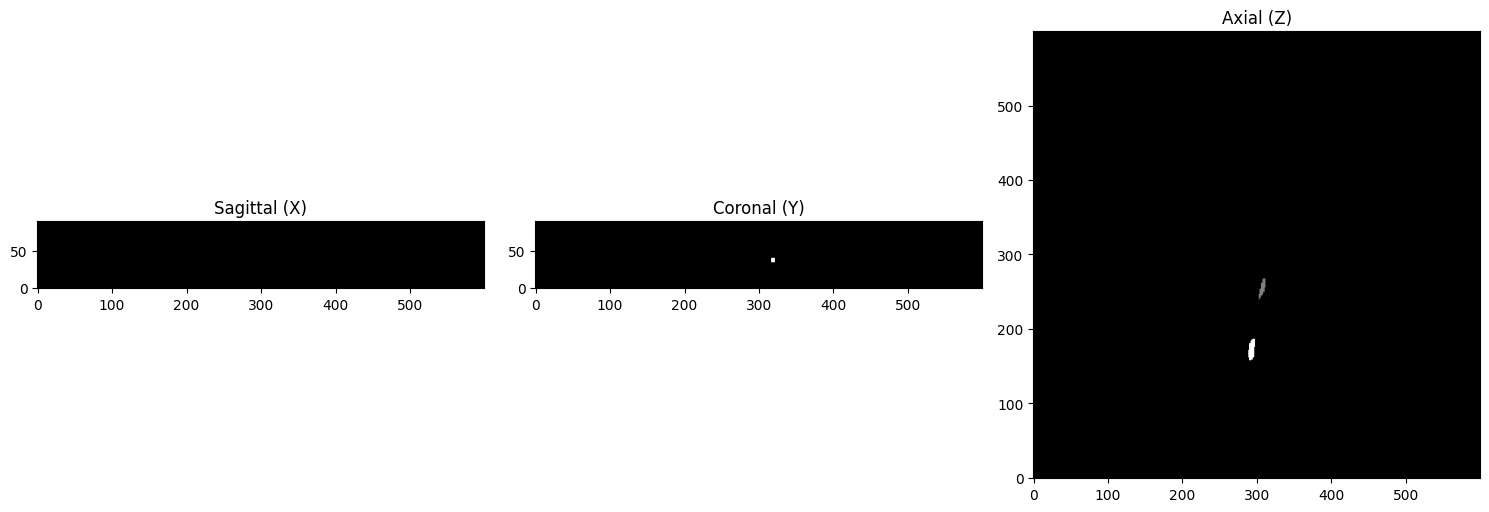

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
i value is

IndexError: list index out of range

In [33]:

# --- Load data ---
X_train, y_train = load_dataset(data_dir, train_ids)


['sub-002']
i and seq are 1 T2
Missing: /content/drive/MyDrive/Colab Notebooks/mri1/sub-002/11-002_T2.nii
{}
i and seq are 2 T2


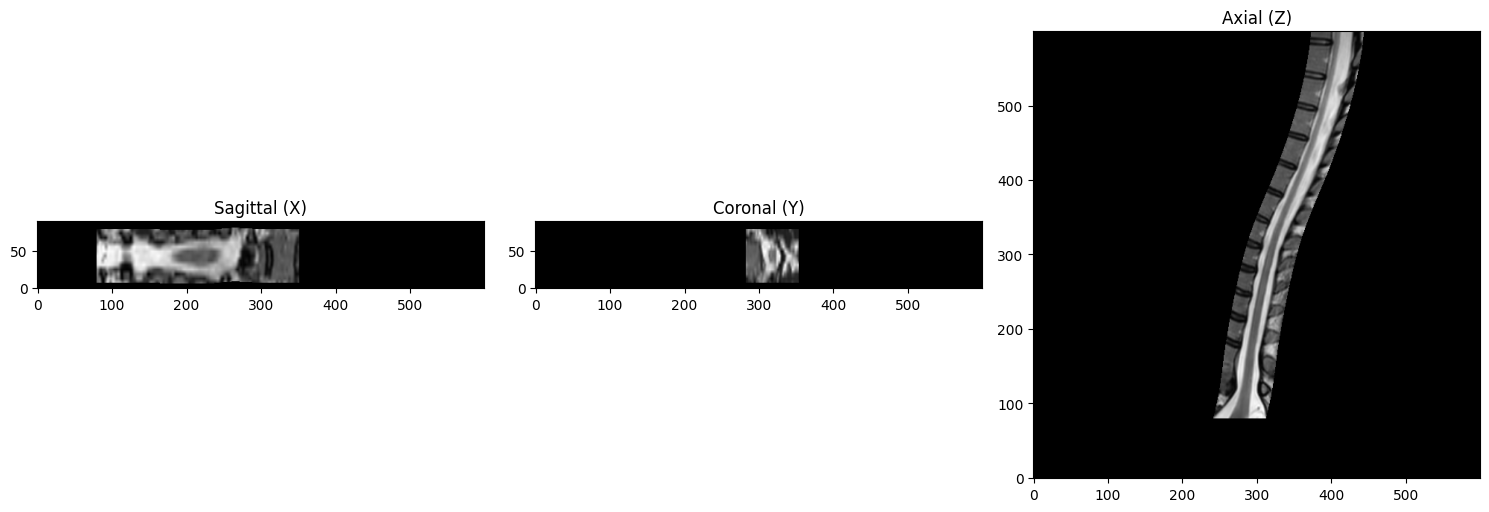

(600, 600, 90)
{}
i and seq are 3 T2
Missing: /content/drive/MyDrive/Colab Notebooks/mri1/sub-002/13-002_T2.nii
{}
i and seq are 1 STIR
Missing: /content/drive/MyDrive/Colab Notebooks/mri1/sub-002/11-002_STIR.nii
{'STIR': '/content/drive/MyDrive/Colab Notebooks/mri1/sub-002/11-002_STIR.nii'}
i and seq are 2 STIR


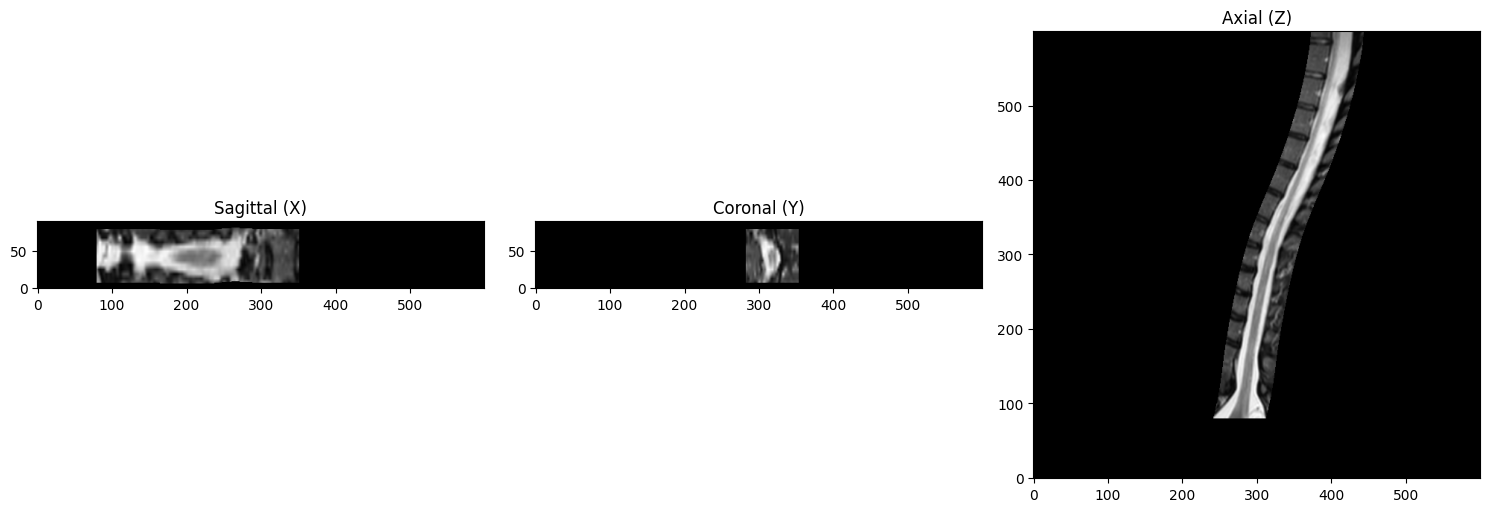

(600, 600, 90)
{'STIR': '/content/drive/MyDrive/Colab Notebooks/mri1/sub-002/12-002_STIR.nii'}
i and seq are 3 STIR
Missing: /content/drive/MyDrive/Colab Notebooks/mri1/sub-002/13-002_STIR.nii
{'STIR': '/content/drive/MyDrive/Colab Notebooks/mri1/sub-002/13-002_STIR.nii'}
i and seq are 1 PSIR
Missing: /content/drive/MyDrive/Colab Notebooks/mri1/sub-002/11-002_PSIR.nii
{'STIR': '/content/drive/MyDrive/Colab Notebooks/mri1/sub-002/13-002_STIR.nii', 'PSIR': '/content/drive/MyDrive/Colab Notebooks/mri1/sub-002/11-002_PSIR.nii'}
i and seq are 2 PSIR
Missing: /content/drive/MyDrive/Colab Notebooks/mri1/sub-002/12-002_PSIR.nii
{'STIR': '/content/drive/MyDrive/Colab Notebooks/mri1/sub-002/13-002_STIR.nii', 'PSIR': '/content/drive/MyDrive/Colab Notebooks/mri1/sub-002/12-002_PSIR.nii'}
i and seq are 3 PSIR
Missing: /content/drive/MyDrive/Colab Notebooks/mri1/sub-002/13-002_PSIR.nii
{'STIR': '/content/drive/MyDrive/Colab Notebooks/mri1/sub-002/13-002_STIR.nii', 'PSIR': '/content/drive/MyDrive/Col

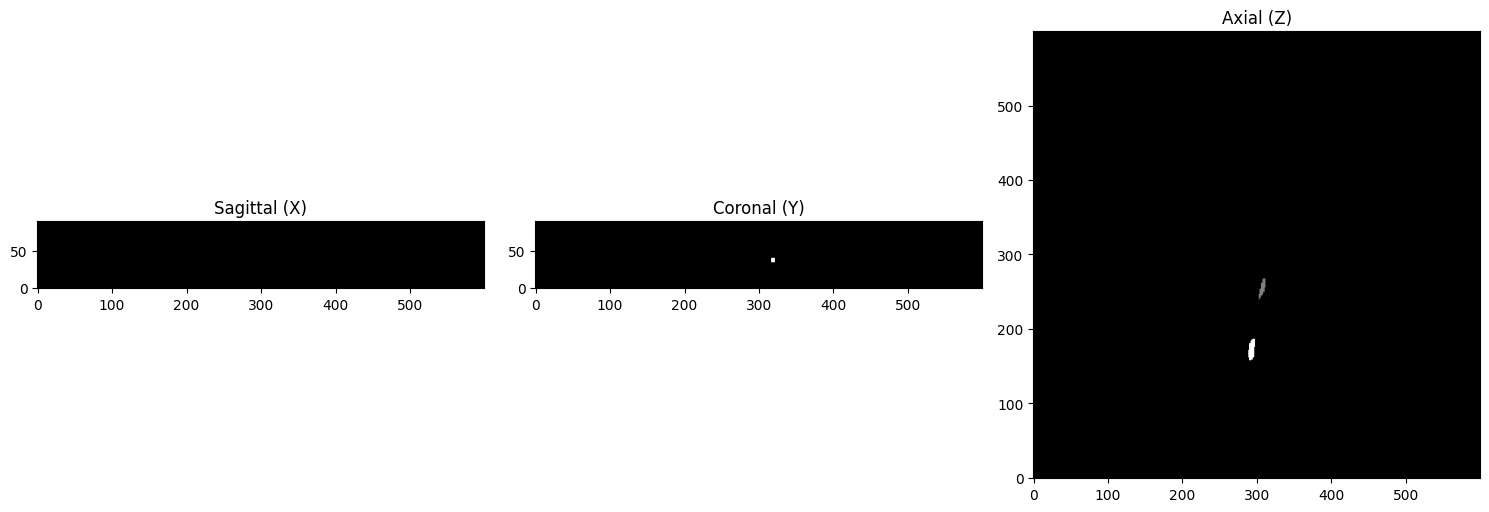

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
i value is

In [ ]:
X_val, y_val = load_dataset(data_dir, val_ids)


In [ ]:
print()